In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from price import *
from kalman import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import dates

(CVXPY) May 02 02:33:28 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 02 02:33:28 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Import data
df = pd.read_csv('data/stock_price.csv', index_col = 0, header=[0,1])
sp500 = pd.read_csv('data/sp500.csv')

In [3]:
close_price = df[['Adj Close']]
close_price.columns = close_price.columns.droplevel(0)
volume = df[['Volume']]
volume.columns = volume.columns.droplevel(0)
# close_price

In [4]:
actual_R_mat = close_price.pct_change()
actual_R_mat = actual_R_mat[1:]

return_matrix = close_price.pct_change().shift(-1)

In [5]:
train_period = 0.2

In [6]:
# Prediction using Kalman Filter
res1 = pd.DataFrame()
res2 = pd.DataFrame()
for fid in tqdm(close_price.columns):
#     print(fid)
    temp_close = close_price[fid]
    temp_volume = volume[fid]
    data = pd.DataFrame({'target':temp_close.shift(-1)/temp_close-1,'return':temp_close/temp_close.shift()-1,'return_vol':temp_volume/temp_volume.shift()-1})
    data.index = temp_close.index.values
    temp_data = data.copy()
    a = pd.DataFrame({fid:calc_kalman(temp_data,train_period)})
    res1 = pd.concat([res1, a], axis = 1)
    temp_data = data.copy()
    a = pd.DataFrame({fid:calc_kalman_multi(temp_data,train_period)})
    res2 = pd.concat([res2, a], axis = 1)
    tempa = np.sign(res1[fid])
    index0 = tempa.dropna().index
    tempa = np.sign(res1[fid])[index0]
    tempb = np.sign(res2[fid])[index0]
    tempc = np.sign(return_matrix[fid][index0])

100%|██████████| 30/30 [03:05<00:00,  6.17s/it]


## Optimization Model

In [7]:
def NPM(r, his_r, x_tilde, theta, c):
    '''
    param r [ndarray]: vector of predicted return at period t
    param his_r [ndarray]: 2d vector of return for the past W periods; his_r[i][j] = price 
    param x_tilde [ndarray]: investment weights at the end of period t-1
    param theta [float]: acceptable risk level in the range of (0, 1), smaller theta could lead to infeasible solution
    param c [float]: transacion cost in the range of (0, 1)

    '''
    M = len(r) # Number of assets in the portfolio
    W = len(his_r) # Number of recents prices used to measure risk
    
    # Define variables
    u = cp.Variable(M)
    v = cp.Variable(M)
    d = cp.Variable(W)
    g = cp.Variable(W)
    
    # Define Objective
    objective = cp.Maximize(r @ x_tilde + (r - c/2) @ u - (r + c/2) @ v)
    
    # Define constraints
    constraints = [cp.sum(u - v) == 0,
                    -(u - v + x_tilde) <= 0,
                    u - v + x_tilde <= 1,
                    u >= 0, v >= 0, d >= 0, g >= 0]
    
    constraints += [cp.sum(d + g) <= W * theta]
    for j in range(W):
#         print('day', -1-j, np.sum(r - his_r[-1-j]))
        constraints += [(his_r[-1-j] - r) @ u - (his_r[-1-j] - r) @ v - d[j] <= (r - his_r[-1-j]) @ x_tilde,
                        (r - his_r[-1-j]) @ u - (r - his_r[-1-j]) @ v - g[j] <= (his_r[-1-j] - r) @ x_tilde]
        
    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose = False, solver='ECOS_BB')
    if problem.status != cp.OPTIMAL:
        print('problem status', problem.status)
#     constraints_value = [constraint.value for constraint in constraints]
#     print(constraints_value)
        
    return problem, u.value, v.value, d.value, g.value

Algorithm

In [44]:
weight_mat = []
assets = close_price.columns

pred_R_mat = res2
actual_R_mat = actual_R_mat 
N = len(pred_R_mat)
num_his = 15 # Number of historical days
init_weight = np.ones(len(assets)) / len(assets) # Start with uniform weight
theta = 10 # Risk level
c = 0.001 # Transaction Cost
start_day = pred_R_mat.iloc[:, 1].first_valid_index()
# print(start_day)
start_day = pred_R_mat.index.get_loc(start_day)

w = init_weight
# weight_mat.append(w)
for t in tqdm(range(start_day,N)):
    # In the paper, return is defined as pt/pt-1, so we should +1
    predicted_return = np.array((pred_R_mat+1).iloc[t][assets])
    historial_w_actual_returns = (actual_R_mat+1).iloc[t - num_his : t, :][assets]
    historial_w_actual_returns = historial_w_actual_returns.values
#     print('day', t)
    problem, u, v, d, g = NPM(predicted_return, historial_w_actual_returns, w, theta, c)
    w = w + u - v
    weight_mat.append(w)

100%|██████████| 2011/2011 [02:19<00:00, 14.43it/s]


Analyze the strategy

In [45]:
signal = pd.DataFrame(np.array(weight_mat), columns = assets, index = actual_R_mat.index[start_day : N])
signal

,AAPL,ABBV,ABT,AMZN,BA,BAC,C,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PFE,PG,T,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-25,1.436490e-11,1.151816e-11,1.387192e-11,1.421252e-11,1.213598e-11,1.363625e-11,1.314356e-11,1.321612e-11,1.571170e-11,1.379896e-11,...,1.245089e-11,1.543268e-11,7.972081e-12,1.464052e-11,1.459426e-11,1.461994e-11,1.415119e-11,1.414217e-11,1.447215e-11,1.454265e-11
2015-03-26,1.289128e-11,1.218674e-11,3.662597e-11,8.282834e-11,1.706474e-11,3.202250e-11,3.900974e-11,1.585264e-11,1.237851e-09,1.308239e-11,...,1.146378e-11,3.787022e-11,5.240698e-12,5.855877e-11,1.826103e-11,3.417780e-11,2.210202e-11,1.449841e-11,2.438769e-11,2.745642e-11
2015-03-27,1.743247e-11,2.545583e-11,1.079652e-10,4.800239e-11,1.379083e-10,2.960281e-11,1.752482e-11,4.730519e-12,2.277136e-11,6.584548e-11,...,1.491383e-11,1.069651e-11,1.061011e-11,2.087583e-10,2.004089e-11,2.741521e-11,2.543830e-10,3.321334e-11,2.235692e-11,1.945781e-11
2015-03-30,9.398696e-10,7.291664e-11,1.328080e-10,7.177022e-10,5.768395e-11,8.139360e-11,1.164880e-10,4.857718e-11,3.577935e-10,9.635232e-11,...,5.539663e-11,2.305301e-10,1.859217e-09,1.788151e-09,8.258701e-11,9.461202e-11,1.000000e+00,5.326832e-11,1.155221e-10,7.425432e-11
2015-03-31,9.749869e-11,1.104435e-11,5.532778e-11,7.656852e-11,1.082860e-10,8.821441e-11,8.283616e-11,1.085850e-10,9.274832e-11,9.722684e-11,...,6.353404e-11,9.750814e-11,4.899184e-11,9.861788e-11,6.958644e-11,7.763722e-11,1.000000e+00,8.822463e-11,6.987642e-11,9.937698e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-14,3.741513e-11,2.562142e-10,3.502375e-11,9.166004e-10,3.765882e-11,1.017694e-11,5.912134e-12,3.248469e-11,3.376545e-11,3.212391e-11,...,1.000000e+00,3.642403e-11,1.806308e-09,2.464816e-11,3.720500e-11,3.664649e-11,3.668157e-11,3.395675e-11,3.670957e-11,3.477909e-11
2023-03-15,7.458498e-11,7.283764e-11,7.156307e-11,6.820696e-11,4.748913e-11,5.447398e-11,6.296928e-11,7.213730e-11,6.116934e-11,6.521653e-11,...,6.891954e-11,7.177347e-11,5.395062e-11,7.306008e-11,7.518724e-11,6.587907e-11,6.838284e-11,7.249364e-11,7.106134e-11,7.260713e-11
2023-03-16,1.031041e-10,9.850082e-11,8.458934e-11,8.604317e-10,7.086546e-11,8.927091e-11,3.117611e-11,1.013388e-10,3.311257e-11,8.934796e-11,...,2.020320e-09,9.563254e-11,3.789610e-09,9.421557e-11,1.020756e-10,8.067125e-11,9.450446e-11,5.648581e-11,9.750913e-11,9.957709e-11


Text(0, 0.5, 'Weight')

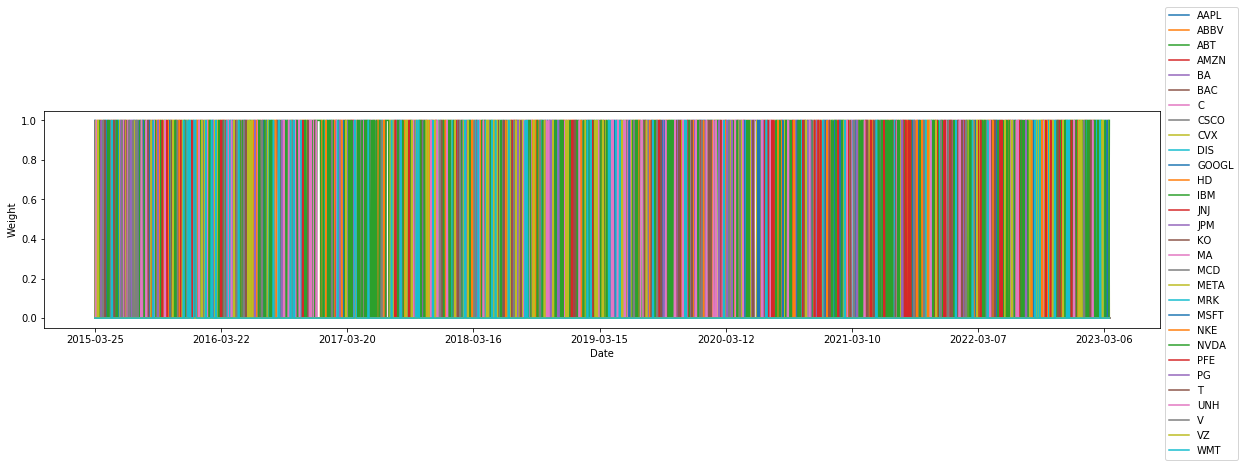

In [46]:
signal.plot(figsize=(20, 4));
plt.legend(signal.columns, loc='best', bbox_to_anchor=(1, 1.5));
plt.xlabel('Date')
plt.ylabel('Weight')

In [47]:
# Benchmark - buy-and-hold
benchmark = actual_R_mat.copy()
benchmark['yield'] = benchmark.apply(lambda x: x.mean(), axis = 1)
benchmark['netvalue'] = benchmark['yield'].cumsum() + 1
benchmark.reset_index(inplace = True)
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

In [48]:
result = signal*return_matrix
result['yield'] = result.apply(lambda x: x.sum(), axis = 1)
result['netvalue'] = result['yield'].cumsum() + 1
# result['netvalue'] = (result['yield']+1).cumprod()
result['draw'] = np.maximum.accumulate(result['netvalue']) - result['netvalue']
result.reset_index(inplace = True)

In [49]:
result['Date'] = pd.to_datetime(result['Date'])
result['draw'] = (result['netvalue']-np.maximum.accumulate(result['netvalue']))
index_j = np.argmax(np.maximum.accumulate(result['netvalue']) - result['netvalue'])  # 结束位置
index_i = np.argmax(result['netvalue'][:index_j])  # 开始位置
index_dif = (result.Date[index_j] -  result.Date[index_i]).days
b = pd.to_datetime(result.Date.values[0])
e = pd.to_datetime(result.Date.values[-1])
years = (e-b).days/252
turnover = np.mean(signal.diff().abs().mean()) # BUG? (axis = 1)？
anyield = (result['netvalue'].iloc[-1]-1-len(signal)*turnover*0.0008/2)/years
maxdraw = np.min(result['draw'])
sharpe = round(result['yield'].mean()/result['yield'].std()*(np.sqrt(252)),4)
calmar = anyield/(-1*maxdraw)
print(maxdraw)
print('sharpe', sharpe)
print('calmar', calmar)

-1.1086666751990615
sharpe 0.1002
calmar 0.018140618817600162


In [50]:
costs = 0.0008 * np.concatenate((np.zeros(len(result.netvalue) - len(signal)+1), signal.diff().abs().sum(axis = 1)[1:]), axis = 0)

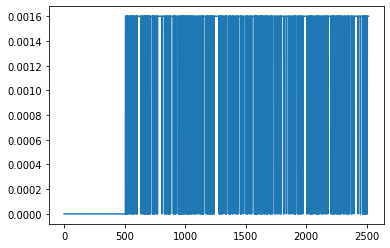

In [51]:
plt.plot(costs)

In [52]:
# return_matrix
target = (return_matrix['AAPL'] + return_matrix['NVDA'])/2
a = target.cumsum() + 1 

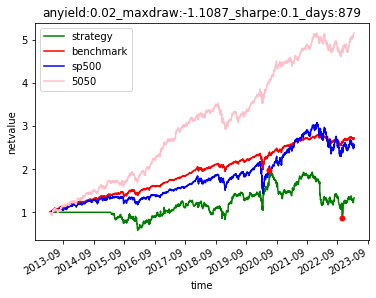

In [53]:
sp500['Date'] = pd.to_datetime(sp500['Date'])

fig = plt.figure()
axis = fig.add_subplot(1, 1, 1)
axis.plot(result.Date,result.netvalue - costs, color = 'green', label = 'strategy')
axis.plot(benchmark.Date,benchmark.netvalue, color = 'red', label = 'benchmark')
axis.plot(sp500.Date,sp500.Close/sp500.Close.iloc[0], color = 'blue', label = 'sp500')
axis.plot(result.Date,a, color = 'pink', label = '5050')

axis.plot([result.Date[index_i], result.Date[index_j]], [result['netvalue'][index_i], result['netvalue'][index_j]], 'o', color="r", markersize=5)
axis.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))  #設置x軸主刻度顯示格式（日期）
axis.xaxis.set_major_locator(dates.MonthLocator(interval = 12))
for label in axis.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
axis.set_title('anyield:'+str(round(anyield,3))+'_maxdraw:'+str(round(maxdraw,4))+'_sharpe:'+str(round(sharpe,3))+'_days:'+str(index_dif))
plt.xlabel('time')
plt.ylabel('netvalue')
plt.legend()
plt.show()